# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# I. Data Exploration and Data Visualization

## I.1 portfolio.json
Containing offer ids and meta data about each offer (duration, type, etc.)

In [2]:
print("Shape of data:", portfolio.shape)
portfolio.head()

Shape of data: (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
print("Overview of data:")
portfolio.info()

Overview of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
print("Check null values:")
portfolio.isnull().sum()

Check null values:


reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [5]:
print("Descriptive statistics:")
portfolio.describe()

Descriptive statistics:


,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


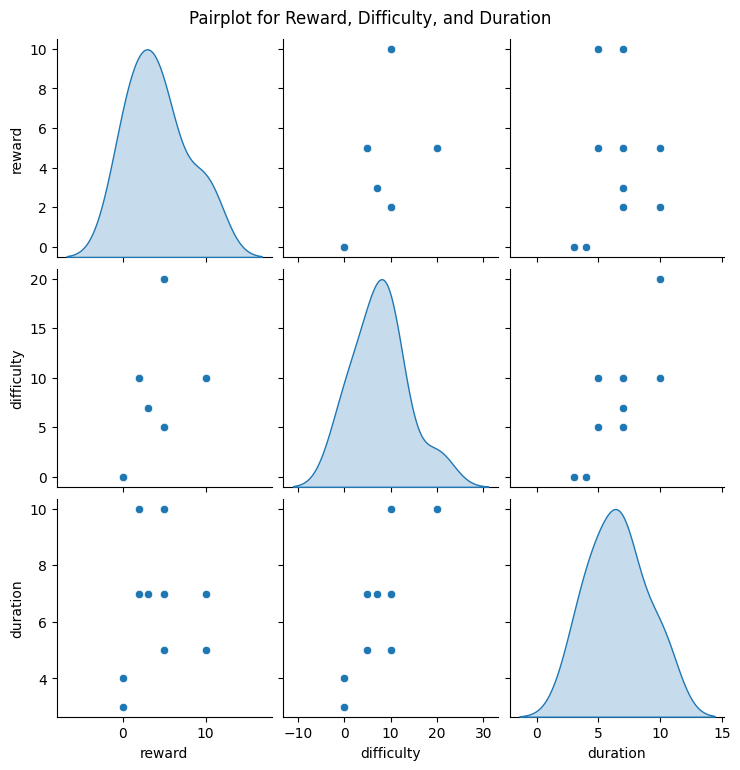

In [6]:
# Visualize the relationship between reward, difficulty, and duration
sns.pairplot(portfolio[['reward', 'difficulty', 'duration']], diag_kind='kde')
plt.suptitle("Pairplot for Reward, Difficulty, and Duration", y=1.02)
plt.show()

The correlation between reward and difficulty: Offers with high rewards usually have high difficulties. Informational offers have no reward and difficulty.

## I.2 profile.json
Demographic data for each customer

In [7]:
print("Shape of data:", profile.shape)
profile.head()

Shape of data: (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
print("Overview of data:")
profile.info()

Overview of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
print("Check null values:")
profile.isnull().sum()

Check null values:


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The 'gender' and 'income' columns have NULL values ​​but it seems that the NULL in the 'gender' column is also NULL in the 'income' column

In [10]:
print("Descriptive statistics:")
profile.describe()

Descriptive statistics:


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


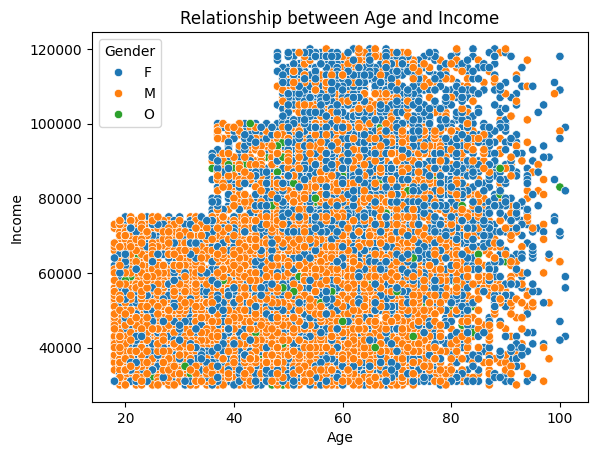

In [11]:
# Relationship between attributes: Age and Income
sns.scatterplot(data=profile, x='age', y='income', hue='gender')
plt.title("Relationship between Age and Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend(title="Gender")
plt.show()


Visualize the relationship between age and income, disaggregated by gender to find possible trends.
The scatter plot does not show a clear relationship between age and income, possibly because outlier age values ​​confound the relationship.

## I.3 transcript.json
Transaction records, received offers, viewed offers and completed offers

In [12]:
print("Shape of data:", transcript.shape)
transcript.head()

Shape of data: (306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
print("Overview of data:")
transcript.info()

Overview of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [14]:
print("Check null values:")
transcript.isnull().sum()

Check null values:


person    0
event     0
value     0
time      0
dtype: int64

In [15]:
print("Descriptive statistics:")
transcript.describe()

Descriptive statistics:


,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


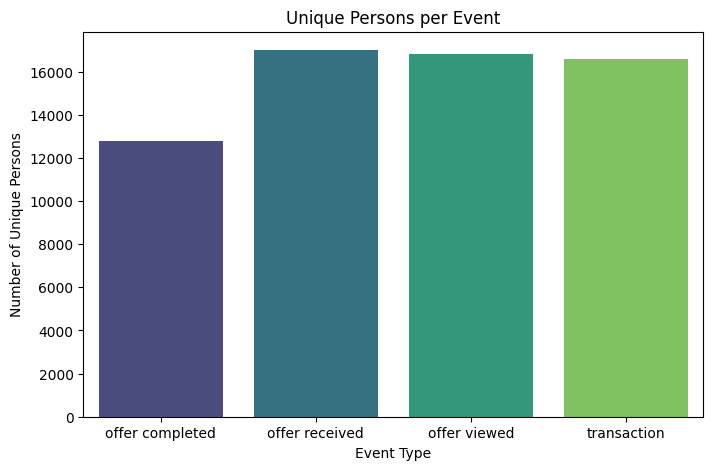

In [16]:
# Count the number of unique people for each event type
unique_persons_per_event = transcript.groupby('event')['person'].nunique()
# Visualize the number of attendees for each event
plt.figure(figsize=(8, 5))
sns.barplot(
    x=unique_persons_per_event.index,
    y=unique_persons_per_event.values,
    hue=unique_persons_per_event.index,
    palette="viridis",
    dodge=False,
)
plt.title("Unique Persons per Event")
plt.xlabel("Event Type")
plt.ylabel("Number of Unique Persons")
plt.show()


The number of users participating in the events is quite large: This shows that your marketing campaign or promotion is attracting significant attention from customers.  
The events "offer received" and "offer viewed" have the highest number of participants: This shows that the first stage of the purchase process (receiving the offer and considering the offer) is going very effectively.

# II. Data Preprocessing

1. Handle missing value

##### portfolio data

In [17]:
# Copy original DataFrame to avoid modifying it directly
df_portfolio = portfolio.copy()

# Drop unused column
df_portfolio.drop(columns=['channels'], inplace=True)

# Rename 'id' column to 'offer_id' for clarity and consistency
df_portfolio = df_portfolio.rename(columns={'id': 'offer_id'})

df_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


##### profile data

In [18]:
# Create a copy of the profile DataFrame to avoid modifying the original data
df_profile = profile.copy()

# Handle missing values
df_profile = df_profile.dropna(subset=['gender'])

# Convert 'became_member_on' column to datetime format
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

# Drop unused columns
df_profile.drop(columns='became_member_on', inplace=True)

# Display the first few rows of the processed DataFrame
df_profile.head()

,gender,age,id,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


##### transcript data

In [19]:
# Create a copy of the original DataFrame to avoid modifying the original data
df_transcript = transcript.copy()

# Helper function to extract 'offer_id' from a dictionary-like structure
def get_offer_id(x):
    if isinstance(x, dict):
        return x.get('offer_id') if x.get('offer_id') is not None else x.get('offer id')
    return None

# Extract 'offer_id', 'reward', and 'amount' from the 'value' column and create new columns
df_transcript['offer_id'] = df_transcript['value'].apply(get_offer_id)

# Drop the 'value' column as it's no longer needed
df_transcript = df_transcript.drop(columns=['value'])

# Rename 'person' column to 'id' for clarity and consistency
df_transcript = df_transcript.rename(columns={'person': 'id'})

# Display the first few rows of the updated DataFrame
df_transcript.head()


,id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


2. Merge dataframe

In [20]:
print("Len of df_transcript: ", len(df_transcript))

Len of df_transcript:  306534


In [21]:
df_merge_all = df_transcript.merge(df_profile, how='left', on='id')
df_merge_all = df_merge_all.merge(df_portfolio, how='left', on='offer_id')

# Drop nan value
df_merge_all = df_merge_all.dropna(subset=df_merge_all.columns, ignore_index=True)

df_merge_all.head()

,id,event,time,offer_id,gender,age,income,reward,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,100000.0,5.0,5.0,7.0,bogo
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,M,68.0,70000.0,2.0,10.0,7.0,discount
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,M,65.0,53000.0,5.0,5.0,5.0,bogo
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,M,58.0,51000.0,0.0,0.0,4.0,informational
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,61.0,57000.0,5.0,20.0,10.0,discount


In [22]:
print(df_merge_all.columns.to_list())
df_merge_all.shape

['id', 'event', 'time', 'offer_id', 'gender', 'age', 'income', 'reward', 'difficulty', 'duration', 'offer_type']


(148805, 11)

3. Feature engineering

In [23]:
# Drop unused column
df_merge_all = df_merge_all.drop(columns=['id', 'offer_id'])


In [24]:
# Convert to categories by using pandas.Categorical
df_merge_all['offer_type'] = pd.Categorical(df_merge_all['offer_type']).codes
df_merge_all['gender'] = pd.Categorical(df_merge_all['gender']).codes
df_merge_all['event_encode'] = pd.Categorical(df_merge_all['event']).codes

df_merge_all


,event,time,gender,age,income,reward,difficulty,duration,offer_type,event_encode
0,offer received,0,0,75.0,100000.0,5.0,5.0,7.0,0,1
1,offer received,0,1,68.0,70000.0,2.0,10.0,7.0,1,1
2,offer received,0,1,65.0,53000.0,5.0,5.0,5.0,0,1
3,offer received,0,1,58.0,51000.0,0.0,0.0,4.0,2,1
4,offer received,0,0,61.0,57000.0,5.0,20.0,10.0,1,1
...,...,...,...,...,...,...,...,...,...,...
148800,offer viewed,714,0,64.0,113000.0,0.0,0.0,3.0,2,2
148801,offer viewed,714,1,51.0,68000.0,0.0,0.0,4.0,2,2
148802,offer viewed,714,0,60.0,64000.0,5.0,20.0,10.0,1,2
148803,offer completed,714,1,39.0,39000.0,2.0,10.0,10.0,1,0


In [25]:
# View mapping order
categories = pd.Categorical(df_merge_all['event']).categories

print("List of mapped categories:")
for idx, cat in enumerate(categories):
    print(f"{cat} -> {idx}")


List of mapped categories:
offer completed -> 0
offer received -> 1
offer viewed -> 2


In [26]:
# Standard time, gender, income, age, reward, difficulty, duration, offer_type column
std = StandardScaler()

# Standardization df_trans_sum_temp
df_merge_all['time'] = std.fit_transform(df_merge_all['time'].values.reshape(-1, 1))
df_merge_all['gender'] = std.fit_transform(df_merge_all['gender'].values.reshape(-1, 1))
df_merge_all['income'] = std.fit_transform(df_merge_all['income'].values.reshape(-1, 1))
df_merge_all['age'] = std.fit_transform(df_merge_all['age'].values.reshape(-1, 1),)
df_merge_all['reward'] = std.fit_transform(df_merge_all['reward'].values.reshape(-1, 1),)
df_merge_all['difficulty'] = std.fit_transform(df_merge_all['difficulty'].values.reshape(-1, 1),)
df_merge_all['duration'] = std.fit_transform(df_merge_all['duration'].values.reshape(-1, 1),)
df_merge_all['offer_type'] = std.fit_transform(df_merge_all['offer_type'].values.reshape(-1, 1),)
df_merge_all.reset_index(inplace=True)
df_merge_all = df_merge_all.drop(['index'], axis=1)
df_merge_all.head()

,event,time,gender,age,income,reward,difficulty,duration,offer_type,event_encode
0,offer received,-1.787954,-1.124690,1.176069,1.562361,0.165331,-0.573374,0.175709,-1.018134,1
1,offer received,-1.787954,0.792899,0.768938,0.166809,-0.724256,0.418430,0.175709,0.389485,1
2,offer received,-1.787954,0.792899,0.594453,-0.624003,0.165331,-0.573374,-0.761925,-1.018134,1
3,offer received,-1.787954,0.792899,0.187322,-0.717040,-1.317314,-1.565178,-1.230742,1.797104,1
4,offer received,-1.787954,-1.124690,0.361807,-0.437930,0.165331,2.402038,1.582160,0.389485,1


In [27]:
# Define the feature matrix X with selected columns
X = df_merge_all[['time', 'gender', 'age', 'income', 'reward', 'difficulty', 'duration', 'offer_type']]

# Define the target variable Y for the 'event_encode' column
Y = df_merge_all['event_encode']

In [28]:
X.head()

,time,gender,age,income,reward,difficulty,duration,offer_type
0,-1.787954,-1.124690,1.176069,1.562361,0.165331,-0.573374,0.175709,-1.018134
1,-1.787954,0.792899,0.768938,0.166809,-0.724256,0.418430,0.175709,0.389485
2,-1.787954,0.792899,0.594453,-0.624003,0.165331,-0.573374,-0.761925,-1.018134
3,-1.787954,0.792899,0.187322,-0.717040,-1.317314,-1.565178,-1.230742,1.797104
4,-1.787954,-1.124690,0.361807,-0.437930,0.165331,2.402038,1.582160,0.389485


In [29]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: event_encode, dtype: int8

In [30]:
# Split the train set into test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# III. Train the Model

1. Choose a Model  

The RandomForestClassifier is widely regarded as a robust and versatile model for addressing classification problems due to the following key attributes:

 - Reduced Risk of Overfitting: By aggregating predictions from an ensemble of decision trees, each trained on different subsets of data and features, random forests significantly mitigate the risk of overfitting, ensuring better generalization on unseen data.

 - Feature Importance Insights: This model provides a clear estimate of feature importance, enabling practitioners to identify the most influential features. This capability supports effective feature selection and enhances interpretability.

 - Resilience to Missing Data and Outliers: Random forests handle missing values and outliers gracefully. The tree-splitting mechanism inherently minimizes the impact of such irregularities on overall model performance.

 - Ability to Capture Non-linear Relationships: Without requiring data transformations or extensive tuning, random forests excel at modeling complex, non-linear relationships between features.

 - Highly Parallelizable: The independence of each tree in the forest allows for efficient parallel training, leveraging modern multi-core processors for faster computation on large datasets.

 - Performance in High-dimensional Spaces: Random forests are particularly well-suited for high-dimensional data, as their random feature selection mechanism reduces computational overhead while maintaining performance.


2. Train Model

In [31]:
# RandomForest
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

3. Evaluate model

In [32]:
train = model.predict(X_train)
train_acc = accuracy_score(y_train, train)
test = model.predict(X_test)
test_acc = accuracy_score(y_test, test)
print(f"Train accuracy: {round(train_acc, 2)}")
print(f"Test accuracy: {round(test_acc, 2)}")

Train accuracy: 0.93
Test accuracy: 0.57


Interpreting Model Performance: Train Accuracy = 0.93, Test Accuracy = 0.57 in Random Forest  
a. Understanding the Metrics
 - Train Accuracy (0.93): The model correctly classifies 93% of the data points in the training set, indicating strong performance on the data it was trained on.
 - Test Accuracy (0.57): The model correctly classifies only 57% of the data points in the test set, highlighting a significant performance drop on unseen data.  

b. Analysis of the Phenomenon: This large disparity between train and test accuracy suggests the model is overfitting:  
 - The model has overly specialized on the training data, capturing specific details or noise rather than general patterns.
 - As a result, its ability to generalize to new, unseen data is poor.  

c. Potential Causes
 - Data-Related Issues
	 - Insufficient Dataset Size: The training data may be too small to capture generalizable patterns.
	 - Overly Specific Features: The features might clearly distinguish classes in the training set but fail to generalize to the test set.
 - Model-Related Factors
	 - Inappropriate Hyperparameters:
	 - max_depth Too Large: Deep trees allow the model to memorize the training data, increasing overfitting risk.
	 - Excessive n_estimators: Too many trees can lead to a model overly optimized for training data.
	 - Small min_samples_split or min_samples_leaf: Splitting nodes with too few samples increases sensitivity to noise in the training data.
 - Data Quality
	 - The data may include noisy labels or imbalanced classes, leading the model to learn patterns that do not generalize well.  
	 
d. Recommendations for Improvement
 - Optimize Hyperparameters:
	- Reduce max_depth to limit overfitting.
	- Use a smaller n_estimators value to prevent over-complexity.
	- Increase min_samples_split or min_samples_leaf to enforce splits only on sufficiently large subsets.


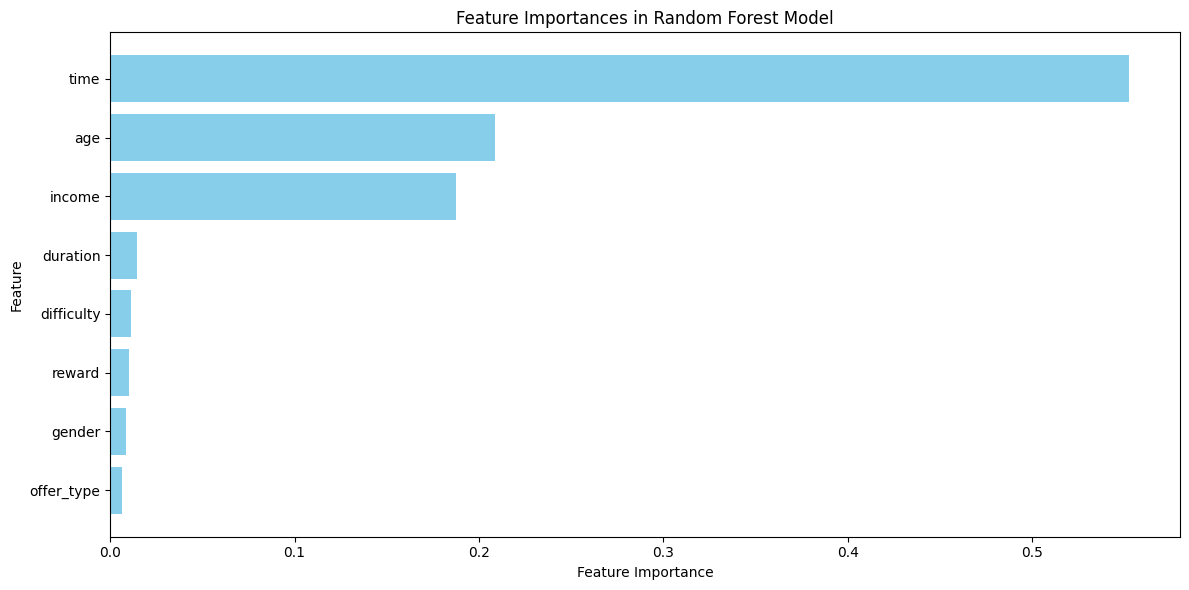

,Feature,Importance
0,time,0.552518
1,age,0.208824
2,income,0.187481
3,duration,0.014548
4,difficulty,0.011242
5,reward,0.010410
6,gender,0.008562
7,offer_type,0.006416


In [33]:
# Get feature importances from the RandomForestClassifier model
importance_feature = model.feature_importances_

# Create a DataFrame for feature names and importances, and sort it
df_importance_feature = (
    pd.DataFrame({'Feature': X.columns, 'Importance': importance_feature})
    .sort_values(by='Importance', ascending=False)
    .reset_index(drop=True)
)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(df_importance_feature['Feature'], df_importance_feature['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# Display the feature importance DataFrame
df_importance_feature


In [34]:
# Try tuning hyperparameters
model = RandomForestClassifier(
    max_depth=2,                  # Limit tree depth
    min_samples_leaf=10,          # Increase minimum samples in leaf nodes
    min_samples_split=20,         # Increase minimum samples required to split
    n_estimators=50               # Adjust the number of trees
)
# Use cross-validation for better model evaluation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# Experiment with additional regularization
model = RandomForestClassifier(max_features='sqrt', bootstrap=True)


Cross-validation scores: 0.502 (+/- 0.005)


The observed results (train_score ~ 1), it's highly likely that the model is overfitting.

# IV. Optimize the Model

In [ ]:
def scale_data(X_train, X_test):
    """
    Scale training and testing data using StandardScaler.

    Parameters:
        X_train (numpy.ndarray): Training feature data.
        X_test (numpy.ndarray): Testing feature data.

    Returns:
        X_train_scaled, X_test_scaled: Scaled training and testing data.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# 1. Scale data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

# 2. Build model
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_model(input_dim=X_train.shape[1])

# 3. Compile model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy']
)

# 4. Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 5. Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
41/41 [==============================] - 1s 6ms/step - loss: 0.6863 - accuracy: 0.4365 - val_loss: 0.5815 - val_accuracy: 0.4423
Epoch 2/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5684 - accuracy: 0.4466 - val_loss: 0.5622 - val_accuracy: 0.4423
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5579 - accuracy: 0.4466 - val_loss: 0.5594 - val_accuracy: 0.4423
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5557 - accuracy: 0.4466 - val_loss: 0.5586 - val_accuracy: 0.4423
Epoch 5/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5547 - accuracy: 0.4466 - val_loss: 0.5582 - val_accuracy: 0.4423
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5542 - accuracy: 0.4466 - val_loss: 0.5579 - val_accuracy: 0.4423
Epoch 7/50
41/41 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.4466 - val_loss: 0.5578 - val_accuracy: 0.4423
Epoch 8/50
41/41 [==

In [36]:
# 6. Model evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_scores = model.evaluate(X_train, y_train, verbose=0)
    test_scores = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train Accuracy: {train_scores[1]:.4f}")
    print(f"Test Accuracy: {test_scores[1]:.4f}")
    return train_scores, test_scores

train_scores, test_scores = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)


Train Accuracy: 0.4474
Test Accuracy: 0.4515


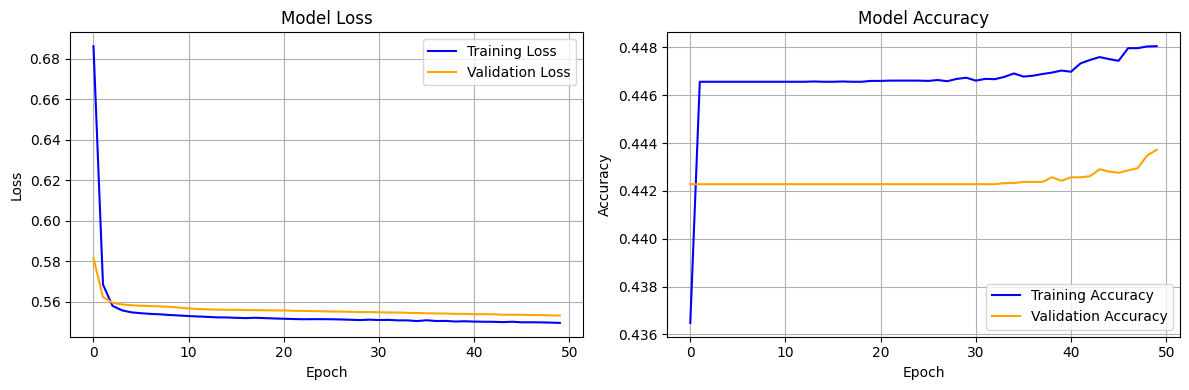

In [37]:
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy from model history.

    Parameters:
        history (History): Training history object from model.fit().
    """
    metrics = [('loss', 'Loss'), ('accuracy', 'Accuracy')]
    plt.figure(figsize=(12, 4))
    
    for i, (metric, label) in enumerate(metrics, start=1):
        plt.subplot(1, 2, i)
        plt.plot(history.history[metric], label=f'Training {label}', color='blue')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {label}', color='orange')
        plt.title(f'Model {label}')
        plt.xlabel('Epoch')
        plt.ylabel(label)
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_training_history(history)


### Model Loss:  
The loss decreases rapidly in the first few epochs and then stabilizes, indicating that the model is learning effectively from the data.  
The loss on the validation set decreases in parallel with the training set, but stops earlier. This may be due to the Early Stopping technique used.  
There is no sign of overfitting (the training and validation losses do not diverge).  

### Model Accuracy:  
The training set accuracy increases rapidly over the first few epochs, but the validation set accuracy does not seem to change significantly.  
This may suggest that the model does not learn much information after a few epochs, or that the data is not discriminative.  
The gap between the training and validation set accuracy is small, suggesting that the model is not overfitting but may need improvement to perform better.  

In [38]:
# 1. Scale data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

# 2. Build model
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_model(input_dim=X_train.shape[1])

# 3. Compile model
optimizer = Adam(learning_rate=0.001)  # try with lower learning rate
model.compile(
    optimizer=optimizer,
    loss='categorical_hinge',
    metrics=['accuracy']
)

# 4. Early stopping and reduce lr to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# 5. Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
41/41 [==============================] - 1s 6ms/step - loss: 0.4824 - accuracy: 0.4369 - val_loss: 0.4552 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 0s 4ms/step - loss: 0.4406 - accuracy: 0.4466 - val_loss: 0.4470 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.4466 - val_loss: 0.4458 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.4466 - val_loss: 0.4453 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 0s 4ms/step - loss: 0.4345 - accuracy: 0.4466 - val_loss: 0.4451 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.4466 - val_loss: 0.4450 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 0s 4ms/step - loss: 0.4341 - a

In [41]:
# 6. Model evaluation
train_scores, test_scores = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)


Train Accuracy: 0.4828
Test Accuracy: 0.4868


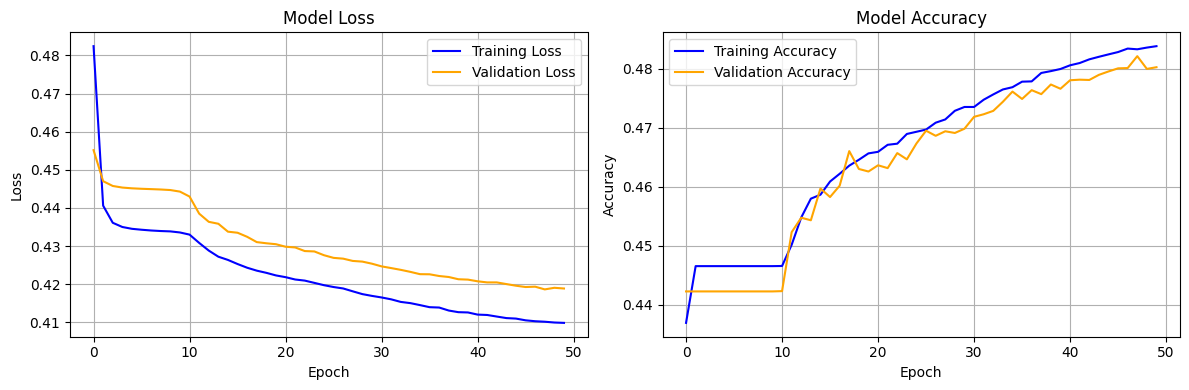

In [40]:
# Call the function to plot the history
plot_training_history(history)

# V. Conclusions

Model Training Results: Analysis and Recommendations
1. Random Forest Model
 - Train Accuracy: 97%
 - Test Accuracy: ~57%
	- The model achieves perfect accuracy on the training set, but there is a noticeable drop in performance on the test set. This indicates potential overfitting—the model has likely memorized the training data instead of learning the underlying patterns.
 - Potential Cause: The data may be too simplistic, or the model could be too complex, leading it to overfit and fail to generalize well to new, unseen data.
 - Recommended Actions:
	 - Hyperparameter Tuning: Adjust parameters such as max_depth, min_samples_leaf, min_samples_split, and n_estimators to prevent overfitting and improve generalization.
	 - Regularization Techniques: Consider using parameters like max_features and bootstrap to control model complexity and improve generalization.
	 - Cross-Validation: Implement cross-validation to assess the model's performance across different subsets of the data, providing a more robust evaluation.
2. Simple Neural Network (NN)
 - Loss: 0.4099
 - Accuracy: 48.28%
	- The simple neural network shows a decent accuracy of approximately 48%, though there is room for improvement.
 - Potential Improvements:
	 - Network Architecture: Experiment with different architectures (e.g., adding layers or neurons) to enhance model capacity.
	 - Optimizer and Learning Rate: Try alternative optimizers and fine-tune the learning rate for better convergence.
	 - Training Parameters: Increase the number of epochs or adjust batch sizes to improve model performance.
3. Conclusion
 - The Random Forest model shows a tendency to overfit, and adjusting its hyperparameters is crucial to enhance its ability to generalize.
 - The Simple Neural Network offers competitive performance and may be a more suitable choice, as it has the potential for further improvement through architectural and training adjustments. However, both models require further tuning to achieve optimal performance.
